In [25]:
import numpy as np
import pandas as pd 
from scipy.optimize import least_squares
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt

In [27]:
dQI = pd.read_csv('DataForImpact/dQI.csv', index_col=False) 
dQI, dQI_test = train_test_split(dQI, test_size = 0.1, shuffle=False)

/tmp/ipykernel_5938/3874371403.py:1: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dQI = pd.read_csv('DataForImpact/dQI.csv', index_col=False)


GOW model

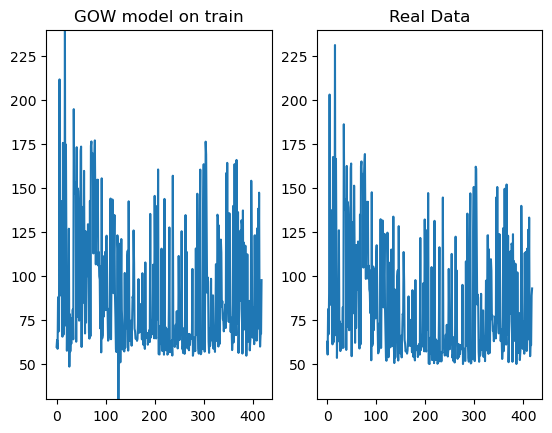

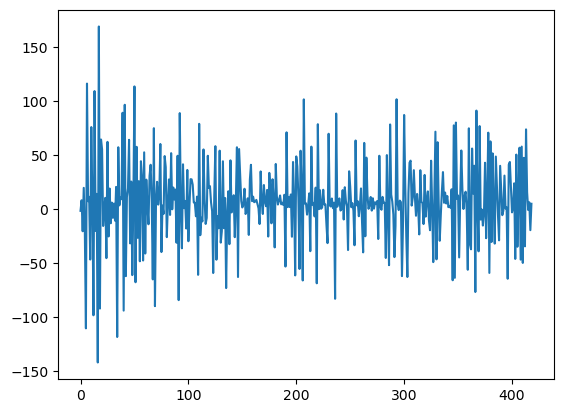

In [20]:
MI = np.array(dQI[' Impact'])
dQ= np.array(dQI[' DeltaQ'])
T = np.array(dQI['Time'])


# Модель 0. Это попробовали:  I_{t+1} = I_{t} * \rho^{t_{i+1} - t_i} + \lamda * dQ

# Модель 1. Описание ниже:
# Всё безобразие сделать в R
# dQ = dQ / (t_{i+1} - t_i)
# Нужно так пересчитать маркет импакт: I_{t+1} = log(S_{t_{i+1}}/S_{t_{i}}) / (t_{i+1} - t_i)
# I_{t+1} = I_{t} * \rho + \lamda * dQ

# Модель 2:
# I_{t+1} = log(S_{t_{i+1}}/S_{t_{i}}) / (dQ_{i+1})
# I_{t+1} = I_{t} * \alpha + \lamda (Можно автоариму попробовать)

# Модель 3. Это попробовали:  I_{t+1} = I_{t} * \rho^{t_{i+1} - t_i} + \lamda * dQ


def fun(x, mi: np.array, mi_prev: np.array, dq: np.array, dt: np.array):
            return np.power(x[0], dt) * mi_prev + x[1] * dq - mi

res_lsq = least_squares(fun, np.array([1., 0.5]), args=(MI[1:], MI[:-1], dQ[1:], np.diff(T)))

Ipred = np.power(res_lsq.x[0], np.diff(T)) * MI[:-1] + res_lsq.x[1] * dQ[:-1]

plt.figure()

plt.subplot(121)
plt.plot(np.arange(len(Ipred)), Ipred)
plt.ylim(30, 240)
plt.title("GOW model on train")
plt.subplot(122)
plt.plot(np.arange(len(MI[1:])), np.array(MI[1:]))
plt.ylim(30, 240)
plt.title("Real Data")

plt.show()

plt.plot(res_lsq.fun)

In [13]:
print(res_lsq)

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-1.432e+00  8.333e+00 ... -1.934e+01  5.091e+00]
           x: [ 9.999e-01  2.238e-02]
        cost: 326417.1414427492
         jac: [[ 3.236e+04  2.045e+02]
               [ 4.307e+04  2.054e+02]
               ...
               [ 9.106e+02  3.969e+02]
               [ 1.332e+03  4.127e+02]]
        grad: [ 8.061e+03  6.518e-03]
  optimality: 8061.375777209535
 active_mask: [ 0.000e+00  0.000e+00]
        nfev: 8
        njev: 8


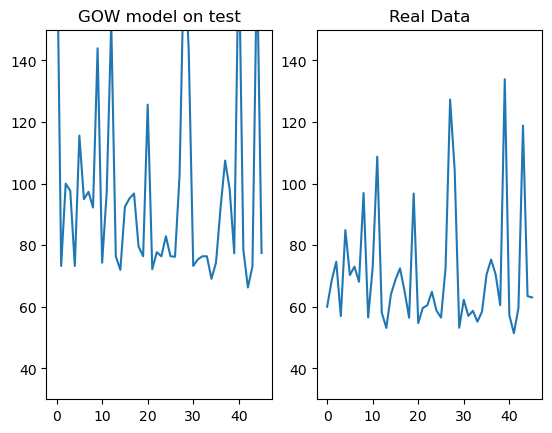

Average percent of mistake:  0.5253933024337112


In [28]:
MI = np.array(dQI_test[' Impact'])
dQ= np.array(dQI_test[' DeltaQ'])
T = np.array(dQI_test['Time'])

Ipred = np.power(res_lsq.x[0], np.diff(T)) * MI[:-1] + res_lsq.x[1] * dQ[:-1]

plt.figure()

plt.subplot(121)
plt.plot(np.arange(len(Ipred)), Ipred)
plt.ylim(30, 150)
plt.title("GOW model on test")
plt.subplot(122)
plt.plot(np.arange(len(MI[1:])), np.array(MI[1:]))
plt.ylim(30, 150)
plt.title("Real Data")

plt.show()

print('Average percent of mistake: ', sum(abs((Ipred - MI[1:])/MI[1:])) / len(Ipred))

Square root model

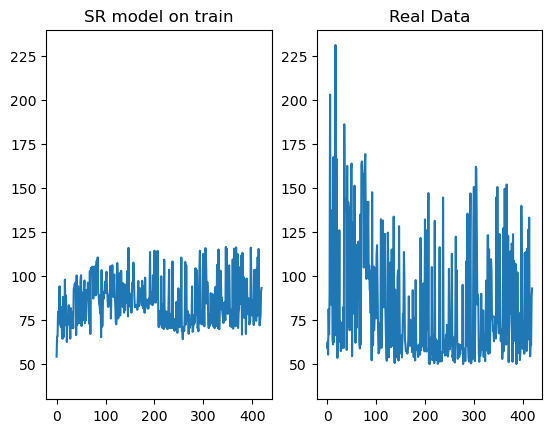

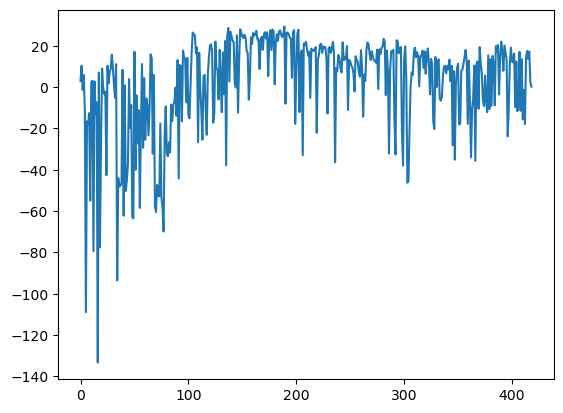

In [29]:
MI = np.array(dQI[' Impact'])
dQ= np.array(dQI[' DeltaQ'])
T = np.array(dQI['Time'])

def fun(x, mi: np.array, dq: np.array):
            return x[0] * np.power(dq, 0.5) - mi 

res_lsq = least_squares(fun, np.array([1.]), args=(MI[1:], dQ[1:])) # могли упасть в локальный минимум


Ipred = res_lsq.x[0] * np.power(dQ, 0.5)

plt.figure()

plt.subplot(121)
plt.plot(np.arange(len(Ipred)), Ipred)
plt.ylim(30, 240)
plt.title("SR model on train")
plt.subplot(122)
plt.plot(np.arange(len(MI)), np.array(MI))
plt.ylim(30, 240)
plt.title("Real Data")

plt.show()

plt.plot(res_lsq.fun) 

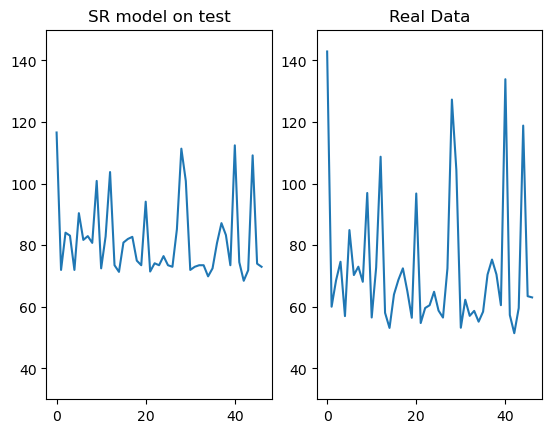

Average percent of mistake:  0.19608889450134853


In [30]:
MI = np.array(dQI_test[' Impact'])
dQ= np.array(dQI_test[' DeltaQ'])
T = np.array(dQI_test['Time'])

Ipred = res_lsq.x[0] * np.power(dQ, 0.5)

plt.figure()

plt.subplot(121)
plt.plot(np.arange(len(Ipred)), Ipred)
plt.ylim(30, 150)
plt.title("SR model on test")
plt.subplot(122)
plt.plot(np.arange(len(MI)), np.array(MI))
plt.ylim(30, 150)
plt.title("Real Data")

plt.show()

print('Average percent of mistake: ', sum(abs((Ipred - MI)/MI)) / len(Ipred))

ARX(2, 1)

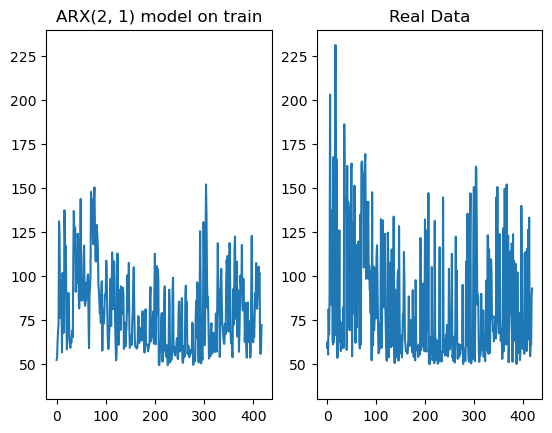

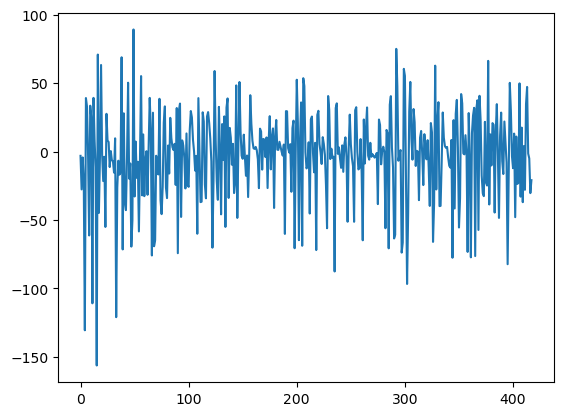

In [31]:
MI = np.array(dQI[' Impact'])
dQ= np.array(dQI[' DeltaQ'])
T = np.array(dQI['Time'])


def fun(x, mi: np.array, mi_prev: np.array, mi_prev_prev:np.array, dq: np.array):
            return x[0] * mi_prev + x[1] * mi_prev_prev +  x[2] * dq - mi

res_lsq = least_squares(fun, np.array([1., 0.5, 1.]), args=(MI[2:], MI[1:-1], MI[:-2], dQ[:-2]))

Ipred = res_lsq.x[0] * MI[1:-1] + res_lsq.x[1] * MI[:-2] +  res_lsq.x[2] * dQ[:-2]

plt.figure()

plt.subplot(121)
plt.plot(np.arange(len(Ipred)), Ipred)
plt.ylim(30, 240)
plt.title("ARX(2, 1) model on train")
plt.subplot(122)
plt.plot(np.arange(len(MI)), np.array(MI))
plt.ylim(30, 240)
plt.title("Real Data")

plt.show()

plt.plot(res_lsq.fun) 

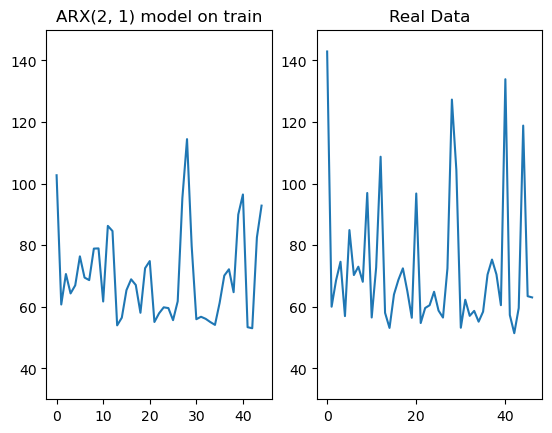

Average percent of mistake:  0.2754883235528584


In [32]:
MI = np.array(dQI_test[' Impact'])
dQ= np.array(dQI_test[' DeltaQ'])
T = np.array(dQI_test['Time'])

Ipred = res_lsq.x[0] * MI[1:-1] + res_lsq.x[1] * MI[:-2] +  res_lsq.x[2] * dQ[:-2]

plt.figure()

plt.subplot(121)
plt.plot(np.arange(len(Ipred)), Ipred)
plt.ylim(30, 150)
plt.title("ARX(2, 1) model on train")
plt.subplot(122)
plt.plot(np.arange(len(MI)), np.array(MI))
plt.ylim(30, 150)
plt.title("Real Data")

plt.show()

print('Average percent of mistake: ', sum(abs((Ipred - MI[2:])/Ipred)) / len(Ipred))

Experiments

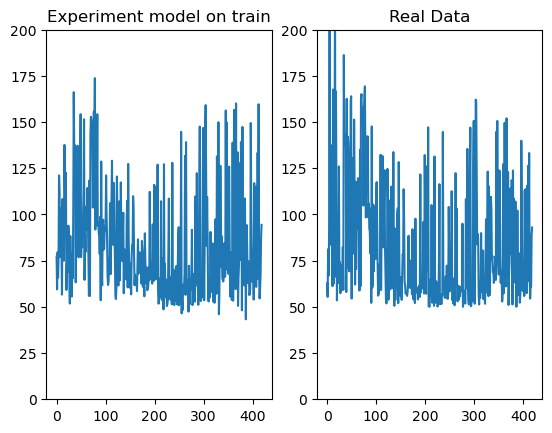

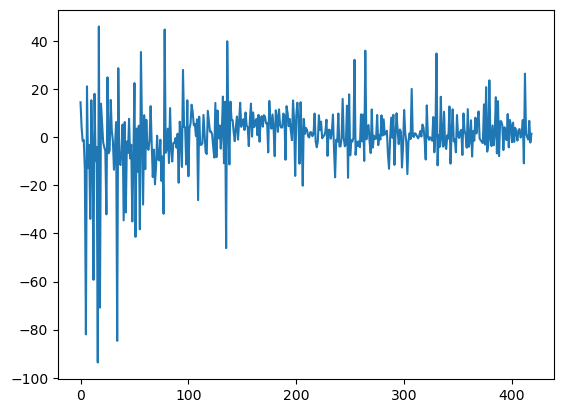

In [47]:
MI = np.array(dQI[' Impact'])
dQ= np.array(dQI[' DeltaQ'])
T = np.array(dQI['Time'])


# Модель 0. Это попробовали:  I_{t+1} = I_{t} * \rho^{t_{i+1} - t_i} + \lamda * dQ

# Модель 1. Описание ниже:
# Всё безобразие сделать в R
# dQ = dQ / (t_{i+1} - t_i)
# Нужно так пересчитать маркет импакт: I_{t+1} = log(S_{t_{i+1}}/S_{t_{i}}) / (t_{i+1} - t_i)
# I_{t+1} = I_{t} * \rho + \lamda * dQ

# Модель 2:
# I_{t+1} = log(S_{t_{i+1}}/S_{t_{i}}) / (dQ_{i+1})
# I_{t+1} = I_{t} * \alpha + \lamda (Можно автоариму попробовать)

# Мсследовать её эконометрически
def fun(x, mi: np.array, mi_prev: np.array, dq: np.array, dq_prev: np.array):
            return (x[0] * mi_prev / dq_prev + x[1]) * dq - mi

res_lsq = least_squares(fun, np.array([1., 1.]), args=(MI[1:], MI[:-1], dQ[1:], dQ[:-1]))

Ipred = (res_lsq.x[0] * MI[:-1] / dQ[:-1] + res_lsq.x[1]) * dQ[1:]

plt.figure()

plt.subplot(121)
plt.plot(np.arange(len(Ipred)), Ipred)
plt.ylim(0, 200)

plt.title("Experiment model on train")
plt.subplot(122)
plt.plot(np.arange(len(MI[1:])), np.array(MI[1:]))
plt.ylim(0, 200)
plt.title("Real Data")

plt.show()

plt.plot(res_lsq.fun)

In [48]:
res_lsq

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 1.448e+01  4.070e+00 ... -2.247e+00  1.411e+00]
           x: [ 7.390e-01  6.311e-02]
        cost: 41088.37603252735
         jac: [[ 8.695e+01  2.045e+02]
               [ 6.296e+01  2.054e+02]
               ...
               [ 8.340e+01  3.969e+02]
               [ 9.247e+01  4.127e+02]]
        grad: [ 1.063e-03  8.638e-03]
  optimality: 0.00863816871878953
 active_mask: [ 0.000e+00  0.000e+00]
        nfev: 4
        njev: 2

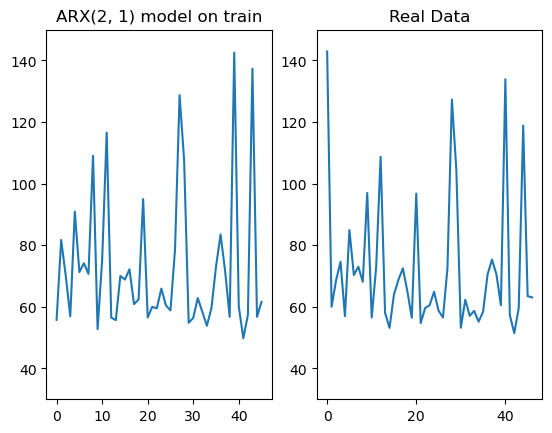

Average percent of mistake:  0.04918752828299278


In [50]:
MI = np.array(dQI_test[' Impact'])
dQ= np.array(dQI_test[' DeltaQ'])
T = np.array(dQI_test['Time'])

Ipred =  (res_lsq.x[0] * MI[:-1] / dQ[:-1] + res_lsq.x[1]) * dQ[1:]

plt.figure()

plt.subplot(121)
plt.plot(np.arange(len(Ipred)), Ipred)
plt.ylim(30, 150)
plt.title("Experemental model on train")
plt.subplot(122)
plt.plot(np.arange(len(MI)), np.array(MI))
plt.ylim(30, 150)
plt.title("Real Data")

plt.show()

print('Average percent of mistake: ', sum(abs((Ipred - MI[1:])/Ipred)) / len(Ipred))

Задачи на слудующий раз:
1. Реализовать модель выше в R
2. Причесать дату
3. Скользящее окно
4. Посмотреть статьи по предсказанию маркет импакта